<a href="https://colab.research.google.com/github/rchartra/Data-Science-in-Oceanography/blob/main/CO_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemical Oceanography (CO)

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/CO/rosette-launch.jpeg?raw=1"/>


This tutorial is part of our Chemical Oceanography day. It demonstrates how to do basic analysis and visualization of chemical element observations in the ocean. The biogeochemical observations on oceanographic research cruises are commonly collected using a Rosette. It is a framework with many sampling bottles clustered around a central cylinder, where other continuous sensor packages can be attached. We'll access typical observations collected via Rosette casts using a variety of methods and try to verify a few fundamental oceanographic principles.


### Estimated tutorial time: 2 hours

## Tutorial goals

- Python Skills
    - Work with dataframes
    - Make different statistical plots
- CO knowledge
    - Learn about the distribution of nutrients in the ocean
    - Understand the acidification and deoxygenation in the ocean
    - Explore the Redfield ratio
    
## Data

- HOT: Hawaii Ocean Time series. Since 1988, the Station ALOHA near Hawaii has been sampled approximately every month as part of the HOT cruises. https://hahana.soest.hawaii.edu/hot/. This data can also be downloaded using CMAP API: https://simonscmap.com/catalog/datasets/HOT_Bottle_ALOHA.
    
## Reading

Ocean acidification https://www.noaa.gov/education/resource-collections/ocean-coasts/ocean-acidification


Gruber, N., & Deutsch, C. A. (2014). Redfield's evolving legacy. Nature Geoscience, 7(12), 853-855. https://www.nature.com/articles/ngeo2308

Moore, C. M., Mills, M. M., Arrigo, K. R., Berman-Frank, I., Bopp, L., Boyd, P. W., ... & Ulloa, O. (2013). Processes and patterns of oceanic nutrient limitation. Nature geoscience, 6(9), 701-710. https://www.nature.com/articles/ngeo1765


# Let's start!

In [ ]:
pip install pycmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 616.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pycmap
import plotly.express as px

import matplotlib.pyplot as plt

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

## Examples of ocean data repositories:  BCO-DMO, CMAP

The **B**iological and **C**hemical **O**ceanography **D**ata **M**anagement **O**ffice is sponsored by NSF and contains an enormous amount of data from many, many cruises - nearly all of those sponsored by the foundation - in open-access formats that are available to the public. https://www.bco-dmo.org/


To download the data using API, please register at CMAP and generate your API key following this link https://simonscmap.com/apikeymanagement


## Specific example: Hawaii Ocean Time series (HOT)

Navigate through this website https://hahana.soest.hawaii.edu/hot/dataaccess.html and you wil find a place to download data in the ASCII format that is commonly used in oceanographic community.

Here is one example file with the CTD data that you can just open in your web browser: https://hahana.soest.hawaii.edu/FTP/hot/ctd/hot-325/h325a0101.ctd. The README file for the HOT data can be found at the first level of the FTP link. In this README file we can learn what the filename -__h325a0101__ meant (HOT 325, Station 1, Cast 1), what the structure of the file is (consistent line length of 65 characters, six header lines) and details about each of the columns.

### Finally we can meaningfully load the HOT data

In [ ]:
data_url_string = "https://hahana.soest.hawaii.edu/FTP/hot/ctd/hot-325/h325a0101.ctd"

ctd_data = pd.read_csv(data_url_string, skiprows=6, sep='\s+', header=None)

name_dict = {0:"pressure", 1:"temperature", 2:"salinity", 3:"oxygen",
             4:"nitrate", 5:"chlorophyll", 6:"nobs", 7:"quality"}

ctd_data = ctd_data.rename(columns=name_dict)

ctd_data = ctd_data.drop(columns=["nobs", "quality"])

ctd_data

,pressure,temperature,salinity,oxygen,nitrate,chlorophyll
0,0.0,26.8851,34.7367,203.1,100.552,0.1607
1,2.0,26.6116,34.7367,203.1,96.018,-0.0203
2,4.0,26.6229,34.7369,203.2,99.220,0.0413
3,6.0,26.6095,34.7370,203.4,99.217,0.1478
4,8.0,26.6003,34.7368,203.3,99.212,0.1610
...,...,...,...,...,...,...
507,1014.0,4.1011,34.5059,49.5,99.748,0.1132
508,1016.0,4.0939,34.5061,49.5,99.748,0.1137
509,1018.0,4.0859,34.5064,49.5,99.749,0.1124
510,1020.0,4.0855,34.5062,49.6,99.750,0.1134


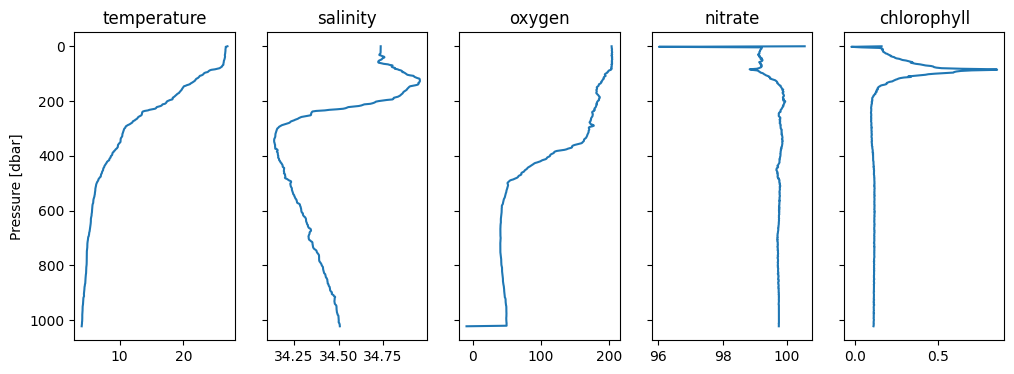

In [ ]:
cols=ctd_data.keys()[1:]

fig, axs=plt.subplots(1,len(cols),figsize=(12, 4))
for j in np.arange(len(cols)):
  axs[j].plot(ctd_data[cols[j]],ctd_data['pressure'])
  axs[j].set_title(cols[j])
  axs[j].invert_yaxis()
  if j>0: axs[j].set_yticklabels([])
axs[0].set_ylabel('Pressure [dbar]');

## Below we proceed with using CMAP's API to query datasets
### CMAP stands for **C**ollaborative **M**arine **A**tlas **P**roject https://simonscmap.com/
-  Get your personal API key by first registering for account on https://simonscmap.com/register and then going to https://simonscmap.com/apikeymanagement to create the key
-  Create a file .cmap_key in the home directory of the system you are using for Jupyterhub notebooks and save the API key there

In [ ]:
key ="5d657a0f-01b9-4ca9-b1d6-fc1b75d32edf"
api = pycmap.API(token=key)       # call api using your unique API key

In [ ]:
# get catalog of all datasets- very long
# api.get_catalog()

# search for a dataset with a specific keyword
# api.search_catalog('carbon')

### HOT: Hawaii Ocean Time-series

In [ ]:
HOT_bottle = api.get_dataset('tblHOT_Bottle')
HOT_bottle.keys()

Index(['botid_HOT', 'time', 'date_time', 'pressure_ctd_bottle_hot',
       'potential_temperature_ctd_bottle_hot',
       'potential_density_ctd_bottle_hot', 'temperature_ctd_bottle_hot',
       'salinity_ctd_bottle_hot', 'oxygen_ctd_bottle_hot',
       'salinity_bottle_hot', 'oxygen_bottle_hot', 'dic_bottle_hot',
       'ph_bottle_hot', 'alk_bottle_hot', 'PO4_bottle_hot',
       'NO2_NO3_bottle_hot', 'SiO4_bottle_hot', 'dop_bottle_hot',
       'don_bottle_hot', 'doc_bottle_hot', 'tdp_bottle_hot', 'tdn_bottle_hot',
       'pc_bottle_hot', 'pn_bottle_hot', 'pp_bottle_hot', 'lln_bottle_hot',
       'llp_bottle_hot', 'chl_bottle_hot', 'phaeo_bottle_hot',
       'HPLC_chl3_bottle_hot', 'HPLC_chl12_bottle_hot',
       'HPLC_chlplus_bottle_hot', 'HPLC_peridinin_bottle_hot',
       'HPLC_but19_bottle_hot', 'HPLC_fuco_bottle_hot',
       'HPLC_hex19_bottle_hot', 'HPLC_prasino_bottle_hot',
       'HPLC_diadino_bottle_hot', 'HPLC_zeaxan_bottle_hot',
       'HPLC_chlb_bottle_hot', 'HPLC_chla_bott

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


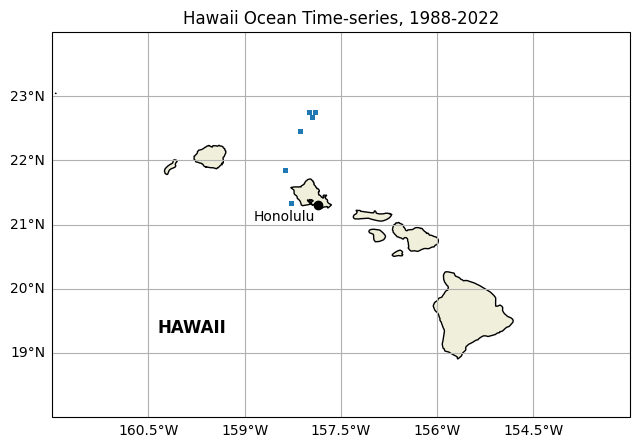

In [ ]:
Lon_Honolulu=360-157.8581; Lat_Honolulu=21.3099

plt.figure(figsize=(15,5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180)); #this specifies which projection to use
ax.set_extent(( 198,207, 18,24), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)

ax.scatter(HOT_bottle['lon'],HOT_bottle['lat'],5,transform=ccrs.PlateCarree())
plt.title('Hawaii Ocean Time-series, 1988-2022')
ax.plot(Lon_Honolulu,Lat_Honolulu, 'ko', alpha=1,transform=ccrs.PlateCarree())

plt.text(Lon_Honolulu-1,Lat_Honolulu-0.25,      # add a text label
         'Honolulu',transform=ccrs.PlateCarree())

plt.text(Lon_Honolulu-2.5,Lat_Honolulu-2,      # add a text label
         'HAWAII',weight="bold", fontsize=12, transform=ccrs.PlateCarree());
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#plt.axis("off");

## Ocean acidification

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/CO/acidification.jpeg?raw=1"/>

https://www.noaa.gov/education/resource-collections/ocean-coasts/ocean-acidification


What is commonly referred to as "acidity" is the concentration of hydrogen ions (H+) in an aqueous solution. The concentration of hydrogen ions is expressed on a logarithmic pH scale scale. Many natural processes affect acidity levels in the environment, including photosynthesis and respiration, so the acidity may vary dramatically as a result of natural biological, physical, and geological processes on a variety of different spatial and temporal scales.

Ocean acidification, related to the uptake of CO2 at the ocean surface, causes a relatively slow, long-term increase in the acidity of the ocean, corresponding to a decrease in pH. Many organisms are very sensitive to seemingly small changes in pH. https://www.pmel.noaa.gov/co2/story/A+primer+on+pH

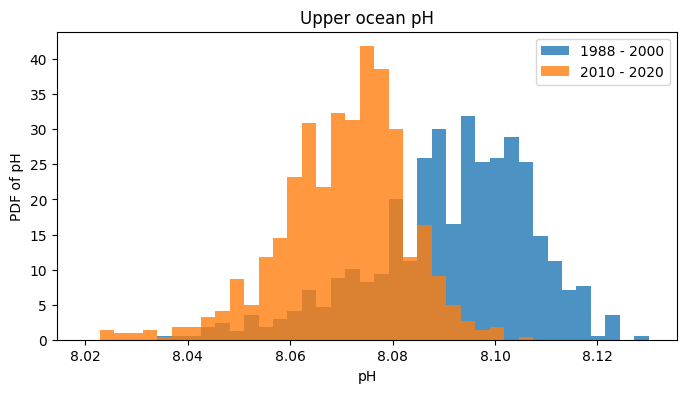

In [ ]:
plt.figure(figsize=(8,4))

ind1=(HOT_bottle['time'] < '2000') & (HOT_bottle['depth'] <100)
plt.hist(HOT_bottle[ind1]['ph_bottle_hot'],
         bins=np.linspace(8.02, 8.13, 40), density=True, alpha=0.8,
         label='1988 - 2000');

ind2=(HOT_bottle['time'] > '2010') &(HOT_bottle['depth'] <100)
plt.hist(HOT_bottle[ind2]['ph_bottle_hot'],
         bins=np.linspace(8.02, 8.13, 40),  density=True,alpha=0.8,
         label='2010 - 2020');

plt.legend()
plt.title('Upper ocean pH')
plt.xlabel('pH')
plt.ylabel('PDF of pH');
plt.savefig('Acidification.pdf');

## In-class exercise \#1: Ocean Deoxygenation

Oxygen is input into the ocean at the surface, through the processes of photosynthesis by phytoplankton and mixing with the atmosphere. However, organisms, both microbial and multicellular, use oxygen in respiration throughout the entire depth of the ocean, so when the supply of oxygen from the surface is less than the utilization of oxygen in deep water, oxygen loss occurs. This phenomenon is natural, but is exacerbated with increased stratification and/or temperature. Stratification occurs when water masses with different properties, primarily temperature and salinity, are layered, with lower density water on top of higher density water. The larger the differences in the properties between layers, the less mixing occurs between the layers. Stratification is increased when the temperature of the surface ocean or the amount of freshwater input into the ocean from rivers and ice melt increases, enhancing ocean deoxygenation by limiting supply. Another factor that can limit supply is the solubility of oxygen. As temperature and salinity increase, the solubility of oxygen decreases, meaning that less oxygen can be dissolved into water as it warms and becomes more salty.

Ocean deoxygenation is an additional stressor on marine life, posing a threat to fish and other types of marine life, as well as to people who depend on marine life for nutrition or livelihood. Total ocean oxygen content has decreased by 1-2% since 1960. https://en.wikipedia.org/wiki/Ocean_deoxygenation



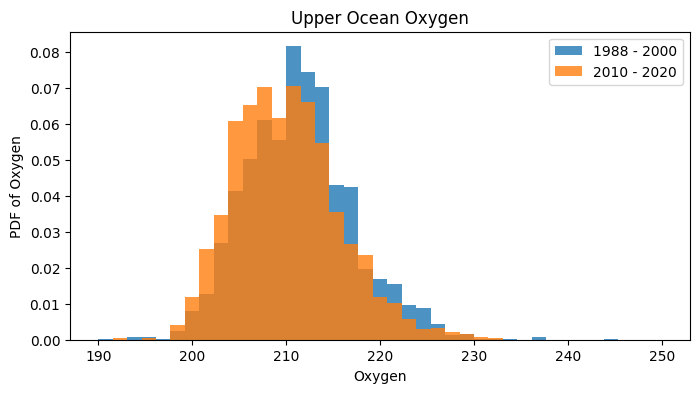

In [ ]:
#your solution goes here
plt.figure(figsize=(8,4))

ind1=(HOT_bottle['time'] < '2000') & (HOT_bottle['depth'] <100)
plt.hist(HOT_bottle[ind1]['oxygen_bottle_hot'],
         bins=np.linspace(190, 250, 40),
         density=True, alpha=0.8,
         label='1988 - 2000');

ind2=(HOT_bottle['time'] > '2010') &(HOT_bottle['depth'] <100)
plt.hist(HOT_bottle[ind2]['oxygen_bottle_hot'], bins=np.linspace(190, 250, 40),
          density=True,alpha=0.8,
         label='2010 - 2020');

plt.legend()
plt.title('Upper Ocean Oxygen')
plt.xlabel('Oxygen')
plt.ylabel('PDF of Oxygen');
plt.savefig('Oxygen.pdf');

In [ ]:
#calculate the fractional O2 change here:
print((np.mean(HOT_bottle[ind2]['oxygen_bottle_hot']) - np.mean(HOT_bottle[ind1]['oxygen_bottle_hot'])) / np.mean(HOT_bottle[ind1]['oxygen_bottle_hot']) * 100)



-0.6343506217585311


## Student's t-test: are the two distributions statistically different?

#### Fun historical note:
The term "t-statistic" is abbreviated from "hypothesis test statistic". The T-Distribution, also known as Student's t-distribution, gets its name from William Sealy Gosset who first published it in English in 1908 in the scientific journal Biometrika using his pseudonym "Student" because his employer preferred staff to use pen names when publishing scientific papers instead of their real name, so he used the name "Student" to hide his identity. Gosset worked at the Guinness Brewery in Dublin, Ireland, and was interested in the problems of small samples – for example, the chemical properties of barley with small sample sizes. Hence a second version of the etymology of the term Student is that Guinness did not want their competitors to know that they were using the t-test to determine the quality of raw material. https://en.wikipedia.org/wiki/Student%27s_t-test

In [ ]:
from scipy.stats import ttest_ind

a = HOT_bottle[ind2]['oxygen_bottle_hot']; a=a[~np.isnan(a)]

b = HOT_bottle[ind1]['oxygen_bottle_hot']; b=b[~np.isnan(b)]

prob=ttest_ind(a,b,equal_var=False).pvalue  # fractional probability that the difference in these two arrays is due to chance

print(prob)

1.3558153525828578e-12


## Nutrients and their deplition at the surface of the ocean

Phytoplankton require a suite of chemicals, and those with the potential to be scarce in surface waters are typically identified as "nutrients." Calcium is an example of an element that is rapidly assimilated by some plankton (for production of calcium carbonate "hard parts") but is not typically considered a nutrient because of its uniformly high concentration in seawater. Dissolved inorganic carbon, which is the feedstock for organic carbon production by photosynthesis, is also abundant and so is not typically listed among the nutrients. However, its acidic form dissolved CO$_2$ is often at adequately low concentrations to affect the growth of at least some phytoplankton.

Sigman, D. M. & Hain, M. P. (2012) The Biological Productivity of the Ocean. Nature Education Knowledge 3(10):21 https://www.nature.com/scitable/knowledge/library/the-biological-productivity-of-the-ocean-70631104/

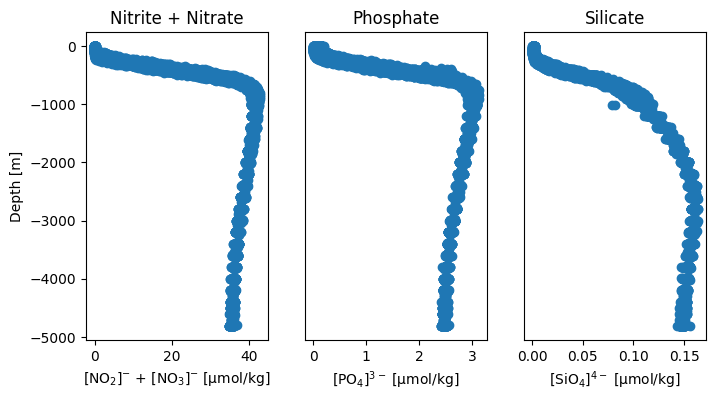

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
plt.scatter(HOT_bottle['NO2_NO3_bottle_hot'],-HOT_bottle['depth'])
plt.xlabel('[NO$_2$]$^{-}$ + [NO$_3$]$^{-}$ [µmol/kg]')
plt.ylabel('Depth [m]')
plt.title('Nitrite + Nitrate')

plt.subplot(1,3,2)
plt.scatter(HOT_bottle['PO4_bottle_hot'],-HOT_bottle['depth'])
plt.xlabel('[PO$_4$]$^{3-}$ [µmol/kg]')
plt.title('Phosphate')
plt.yticks([])

plt.subplot(1,3,3)
plt.scatter(HOT_bottle['SiO4_bottle_hot']/1e3,-HOT_bottle['depth'])
plt.xlabel('[SiO$_4$]$^{4-}$ [µmol/kg]');
plt.title('Silicate')
plt.yticks([]);
plt.savefig('Nutrients.png')

Note how these elements are depleted to near-zero values near the surface of the ocean - why is that?

## Redfield Ratio

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/CO/CNP.png?raw=1" width=600/>

The Redfield ratio is the consistent atomic ratio of carbon, nitrogen and phosphorus found in marine phytoplankton and throughout the deep oceans. It defines the stoichiometry of photosynthesis and remineralization reactions.

The term is named for American oceanographer Alfred C. Redfield who in 1934 first described the relatively consistent ratio of nutrients in marine biomass samples collected across several voyages on board the research vessel Atlantis, and empirically found the ratio to be C:N:P = 106:16:1. While deviations from the canonical 106:16:1 ratio have been found depending on phytoplankton species and the study area, the Redfield ratio has remained an important reference to oceanographers studying nutrient limitation. A 2014 paper summarizing a large data set of nutrient measurements across all major ocean regions spanning from 1970 to 2010 reported the global median C:N:P to be 163:22:1. https://en.wikipedia.org/wiki/Redfield_ratio


Considering only the more numerous and important of the chemical elements in the average recipe for phytoplankton, this leads to an idealized chemical reaction for the formation of phytoplankton:

$106 CO_2 + 16 HNO_3 + H_3PO_4 + 78H_2O \rightleftarrows  (C_{106}H_{175}O_{42}N_{16}P) + 150 O_2.$

The term in parentheses is a simplified average formula for phytoplankton. This equation contains a two-way arrow because the reaction is reversible. The reverse reaction is the remineralization of phytoplankton, brought about by several processes. Nutrients leak back into the environment due to cell breakage during grazing, lysis of cells infected by viruses, decay and lysis of cells attacked by bacteria, excretion of digestive waste products, etc. https://www.sciencedirect.com/science/article/pii/B012227430X002713

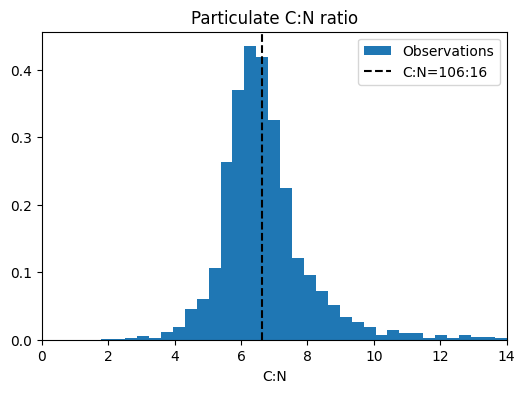

In [ ]:
plt.figure(figsize=(6,4))

plt.hist(HOT_bottle['pc_bottle_hot']/HOT_bottle['pn_bottle_hot'],
         bins=np.linspace(0,14,40),density=True,
         label='Observations');
plt.axvline(106/16,linestyle='--',color='k',label='C:N=106:16')
plt.legend()
plt.title('Particulate C:N ratio')
plt.xlabel('C:N')

plt.xlim((0,14));

## In-class exercise \#2: Nitrogen-to-Phosphorus ratio (N:P)

Following the example above, calculate the Nitrogen-to-Phosphorus ratio (N:P) and plot it as a histogram. Does it match Redfield's ratio of 16:1?

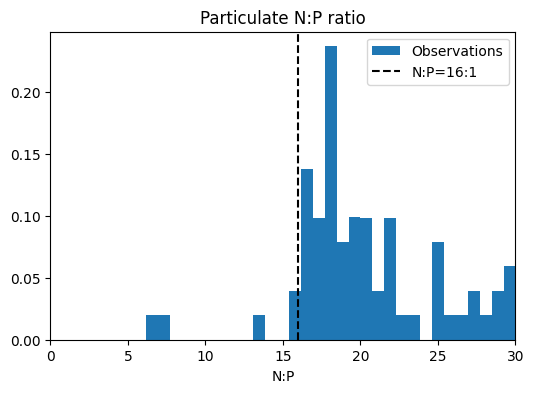

In [ ]:
plt.figure(figsize=(6,4))

plt.hist(HOT_bottle['pn_bottle_hot']*1000/HOT_bottle['pp_bottle_hot'],
         bins=np.linspace(0,30,40),density=True,
         label='Observations');
plt.axvline(16,linestyle='--',color='k',label='N:P=16:1')
plt.legend()
plt.title('Particulate N:P ratio')
plt.xlabel('N:P')

plt.xlim((0,30));

# Seasonal cycle

## Explore there seasonality in surface termperature

In [ ]:
HOT_bottle['month'] = pd.DatetimeIndex(HOT_bottle['time']).month # create a new variable 'month'

ind=(HOT_bottle['depth']<50)  # consider surface data only

fig = px.histogram(HOT_bottle[ind].sort_values(by='month'),
                     x='temperature_ctd_bottle_hot',
                     nbins=15,
                     range_y=[0, 1200],
                     range_x=[22, 29],
                     height=400, width=600,
                     animation_frame="month");
fig.show()

## In-class exercise \#3: Climatology (seasonal cycle)

Calculate the climatological seasonal cycle in temperature and nutrients

### Instructions:
 - subsample the data using near-surface depths, e.g., HOT_bottle['depth']<50

 - To calculate the climatology, group the dataframe variables by month using the __.goupby('month')__ operation and then take an average using __.mean()__
 - Make a scatter plot of month vs temperature and add the climatology figure to it
 - Define a function makes the seasonal cycle  plot of a variable from the dataframe given its name as an argument
 - Use the plotting function to explore different variables like chl_bottle_hot and PO4_bottle_hot

In [ ]:
print(HOT_bottle.keys())

Index(['botid_HOT', 'time', 'date_time', 'pressure_ctd_bottle_hot',
       'potential_temperature_ctd_bottle_hot',
       'potential_density_ctd_bottle_hot', 'temperature_ctd_bottle_hot',
       'salinity_ctd_bottle_hot', 'oxygen_ctd_bottle_hot',
       'salinity_bottle_hot', 'oxygen_bottle_hot', 'dic_bottle_hot',
       'ph_bottle_hot', 'alk_bottle_hot', 'PO4_bottle_hot',
       'NO2_NO3_bottle_hot', 'SiO4_bottle_hot', 'dop_bottle_hot',
       'don_bottle_hot', 'doc_bottle_hot', 'tdp_bottle_hot', 'tdn_bottle_hot',
       'pc_bottle_hot', 'pn_bottle_hot', 'pp_bottle_hot', 'lln_bottle_hot',
       'llp_bottle_hot', 'chl_bottle_hot', 'phaeo_bottle_hot',
       'HPLC_chl3_bottle_hot', 'HPLC_chl12_bottle_hot',
       'HPLC_chlplus_bottle_hot', 'HPLC_peridinin_bottle_hot',
       'HPLC_but19_bottle_hot', 'HPLC_fuco_bottle_hot',
       'HPLC_hex19_bottle_hot', 'HPLC_prasino_bottle_hot',
       'HPLC_diadino_bottle_hot', 'HPLC_zeaxan_bottle_hot',
       'HPLC_chlb_bottle_hot', 'HPLC_chla_bott

<ipython-input-102-9ae5243717eb>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



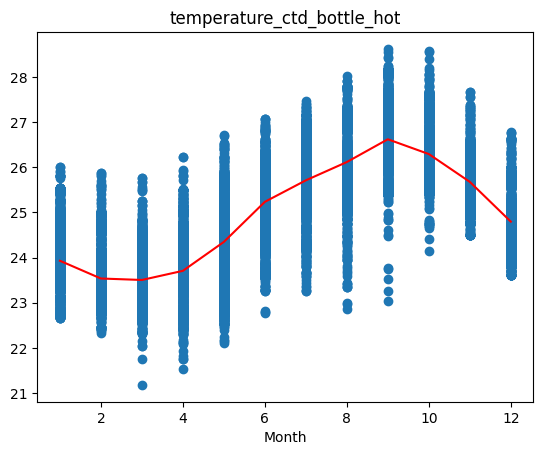

In [ ]:
#Your solution goes here
ind1=(HOT_bottle['depth'] < 50)
surface = HOT_bottle[ind1]
by_month = surface.groupby(['month']).mean()

def seasonal_plot(name):
  plt.scatter(surface['month'], surface[name])
  plt.plot(by_month.index, by_month[name], 'r')
  plt.title(name)
  plt.xlabel('Month')

seasonal_plot('temperature_ctd_bottle_hot')

##  Take-home exercise: Oxygen Minimum Zone

### HOT-DOGS

HOT-DOGS is a user-friendly interface to the data we've looked at in raw form from the CTD above. It stands for the **H**awaii **O**cean **T**ime-series **D**ata **O**rganization & **G**raphical **S**ystem and can be used to download data and make plots. It's still presenting the data in a fairly raw way, but allows us to access single columns over multiple years simultaneously - saving us several steps.

Oxygen Minimum Zone: use the HOT data to demonstrate that the oxygen has a pronounced minimum at depths of a few km. Speculate as to why this might be.

In [ ]:
#hotdogs_data = pd.read_csv("filename.csv")
